# Определение возраста покупателей

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**Цель исследования:** построить модель, которая по фотографии определит приблизительный возраст человека, используя набор фотографий людей с указанием возраста.

**Задачи исследования:**
- выгрузить данные
- провести исследовательский анализ данных:
1) исследовать распределение возраста в размеченных данных
2) посмотреть, как устроен датасет - вывести на экран 10-15 фотографий
- построить модель, доведя метрику до значения не больше 8
- сделать выводы

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**Содержание:**
1. Исследовательский анализ данных
- загрузка библиотек
- выгрузка данных
- распределение возраста в выборке
- распечатанные фотографии выборки (12 шт.)
2. Обучение модели
- загрузка библиотек для обучения модели
- функция load_train
- функция load_test
- функция create_model
- функция train_model
- вывод консоли
3. Анализ обученной модели

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#выгрузим данные

labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
dataframe=labels, directory='/datasets/faces/final_files/',
    x_col='file_name', y_col='real_age', target_size=(224, 224), batch_size=32, 
    class_mode='raw', seed=12345
)

Found 7591 validated image filenames.


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Всего в папке 7591 изображения.

In [3]:
features, target = next(gen_flow)

In [4]:
features.shape

(32, 224, 224, 3)

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Получились признаки, в которые входят четырёхмерные тензоры с 16 изображениями размером 224х224 и 3 цветовыми каналами.

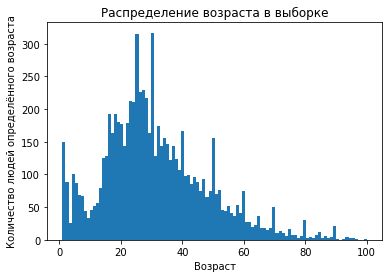

In [6]:
#построим график распределения возраста в выборке
plt.hist(labels['real_age'], bins=100)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество людей определённого возраста');

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

На графике видно, что большая часть покупателей приходится на диапазон от ~20 до ~40 лет.

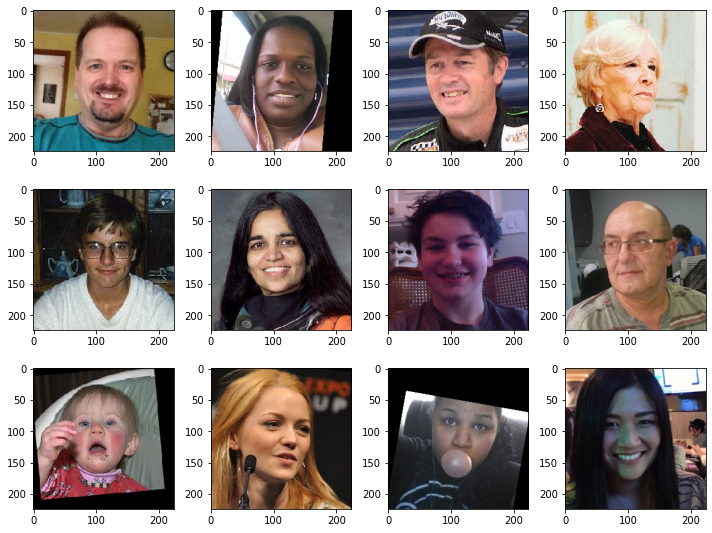

In [7]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Можно заметить, что некоторые фотографии повёрнуты, многие из них плохого качества, сделаны с разных ракурсов и помимо лица имеют другие заметные объекты. Модель обрабатывает абсолютно всю информацию, и эти детали затрудняют её обучение, потому что она не сразу выявляет нужные для определения возраста признаки.

## Обучение модели

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Перенесу сюда код обучения модели и её результат вывода на экран.

(Код в запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
  labels = pd.read_csv(path + 'labels.csv')
  train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True, rotation_range=30)
  train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path+'/final_files',
      x_col='file_name', y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      seed=12345,
      subset='training')
  return train_datagen_flow

def load_test(path):
  labels = pd.read_csv(path + 'labels.csv')
  test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
  test_datagen_flow = test_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=path+'/final_files',
      x_col='file_name', y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      seed=12345,
      subset='validation')
  return test_datagen_flow

def create_model(input_shape):
  optimizer = Adam(lr=0.0001)
  backbone = ResNet50(input_shape=input_shape, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top=False)
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
  if steps_per_epoch is None:
    steps_per_epoch = len(train_data)
  if validation_steps is None:
      validation_steps = len(test_data)
  model.fit(train_data, validation_data=test_data, batch_size=batch_size, \
            epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, shuffle=True)
  return model

```

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

**Вывод консоли:**

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-06-24 07:28:12.324576: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-24 07:28:12.626458: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 97s - loss: 225.4577 - mae: 10.7917 - val_loss: 698.7277 - val_mae: 21.4884
Epoch 2/10
356/356 - 90s - loss: 105.9606 - mae: 7.8548 - val_loss: 205.7432 - val_mae: 10.8124
Epoch 3/10
356/356 - 89s - loss: 87.8643 - mae: 7.1148 - val_loss: 76.4128 - val_mae: 6.5362
Epoch 4/10
356/356 - 89s - loss: 71.2291 - mae: 6.4201 - val_loss: 111.0576 - val_mae: 8.2614
Epoch 5/10
356/356 - 89s - loss: 61.1568 - mae: 5.9623 - val_loss: 114.5498 - val_mae: 7.7103
Epoch 6/10
356/356 - 89s - loss: 53.8792 - mae: 5.6235 - val_loss: 88.4612 - val_mae: 7.0440
Epoch 7/10
356/356 - 89s - loss: 45.8219 - mae: 5.2134 - val_loss: 75.8461 - val_mae: 6.6605
Epoch 8/10
356/356 - 90s - loss: 41.2771 - mae: 4.9171 - val_loss: 75.2246 - val_mae: 6.4574
Epoch 9/10
356/356 - 89s - loss: 38.4377 - mae: 4.7624 - val_loss: 102.4006 - val_mae: 7.8609
Epoch 10/10
356/356 - 89s - loss: 32.3194 - mae: 4.3942 - val_loss: 73.6330 - val_mae: 6.4950
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 73.6330 - mae: 6.4950
Test MAE: 6.4950

```

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Всего было 10 эпох обучения, нужный результат метрики МАЕ меньше 8 удалось достичь на 3 эпохе, однако результат стал стабильным только после 5 эпохи.

## Анализ обученной модели

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

В построении модели я использовала архитектуру ResNet50, не замораживая сеть, т.к. в датасете 7591 изображений - достаточно для того, чтобы сеть не переобучалась. В обучении сети использовали ротации - горизонтальный поворот и вращение на 30 градусов. В качестве функции потерь использовала MSE.

За 10 эпох удалось снизить метрику MAE до 6.5 - меньше, чем 8. 

Целями определения возраста были:
- анализ покупок и предложения товаров для возрастных групп: модель может помочь в определении потенциально подходящих товаров для покупателя, т.к. разница в 6 лет не меняет предпочтения покупателей кардинально;
- контроль продажи алкоголя: модель не способна справиться с определением возраста покупателей с точностью, достаточной для продажи алкоголя, т.к. для этого требуется определять точность до дня.

<div class="alert alert-info" style="border:solid purple 2px; padding: 20px; background-color: #e6d2f2; color: #4b0082;">

Улучшить качество модели можно увеличением выборки с помощью аугментаций.